In [1]:
# Features : OHLCV, RSI, MACD, MFI, EMA50, EMA200, EMA5, EMA13, EMA26

In [2]:
import numpy as np
import yfinance as yf
import sklearn
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
import keras

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.metrics import MeanAbsoluteError
from keras.callbacks import EarlyStopping

In [5]:
end = datetime.date.today()
start = datetime.date(end.year-10, end.month-1, end.day)
end_next = end + pd.DateOffset(days=6)
idx = pd.date_range(start, end)

In [6]:
nifty = yf.download(tickers = "^NSEI", start = start, end = end)

nifty['Return'] = nifty['Close'].pct_change() * 100
nifty['RSI'] = ta.rsi(nifty['Close'])
nifty['EMA5'] = ta.ema(nifty['Close'], length=5)
nifty['EMA13'] = ta.ema(nifty['Close'], length=13)
nifty['EMA26'] = ta.ema(nifty['Close'], length=26)
nifty['EMA50'] = ta.ema(nifty['Close'], length=50)
nifty['EMA200'] = ta.ema(nifty['Close'], length=200)
nifty['MACD'] = nifty['EMA26'] - nifty['EMA13']
nifty['MFI'] = ta.mfi(nifty['Close'], low = nifty['Low'], close = nifty['Close'], volume = nifty['Volume'])
nifty['Open_per'] = nifty['Open'].pct_change() * 100
nifty['High_per'] = nifty['High'].pct_change() * 100
nifty['Low_per'] = nifty['Low'].pct_change() * 100
nifty['Close_L'] = nifty['Close'].shift(-1)

nifty = nifty.reindex(idx)

nifty['MarketOpen/Close'] = nifty.isnull().any(axis=1)
nifty = nifty.interpolate()
nifty['MarketOpen/Close'] = nifty['MarketOpen/Close'].astype(int)
nifty = nifty.dropna()
date_range = pd.date_range(start=end, end=end_next)
nifty_next = pd.DataFrame(index=date_range, columns=['Open_per', 'High_per', 'Low_per', 'Return', 'Volume','RSI', 'EMA5', 'EMA13', 'EMA26', 'EMA50', 'EMA200', 'MFI', 'MarketOpen/Close'])
nifty_next = nifty_next[nifty_next.index.weekday < 5]

nifty.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Return,RSI,EMA5,EMA13,EMA26,EMA50,EMA200,MACD,MFI,Open_per,High_per,Low_per,Close_L,MarketOpen/Close
2024-01-31,21487.250000,21741.349609,21448.849609,21725.699219,21725.699219,410600.0,0.946003,55.753089,21600.525368,21586.785736,21471.981143,21117.230707,19786.849042,-114.804593,52.504535,-1.324868,-0.328708,-0.246264,21697.449219,0
2024-02-01,21780.650391,21832.949219,21658.750000,21697.449219,21697.449219,332500.0,-0.130030,55.083331,21632.833318,21602.594805,21488.682482,21139.984374,19805.859989,-113.912323,53.596515,1.365463,0.421315,0.978609,21853.800781,0
2024-02-02,21812.750000,22126.800781,21805.550781,21853.800781,21853.800781,442800.0,0.720599,58.084509,21706.489139,21638.481373,21515.728282,21167.977174,19826.237510,-122.753091,55.640771,0.147377,1.345909,0.677790,21853.800781,1
2024-02-03,21812.750000,22126.800781,21805.550781,21853.800781,21853.800781,442800.0,0.720599,58.084509,21706.489139,21638.481373,21515.728282,21167.977174,19826.237510,-122.753091,55.640771,0.147377,1.345909,0.677790,21853.800781,1
2024-02-04,21812.750000,22126.800781,21805.550781,21853.800781,21853.800781,442800.0,0.720599,58.084509,21706.489139,21638.481373,21515.728282,21167.977174,19826.237510,-122.753091,55.640771,0.147377,1.345909,0.677790,21853.800781,1


<Figure size 640x480 with 0 Axes>

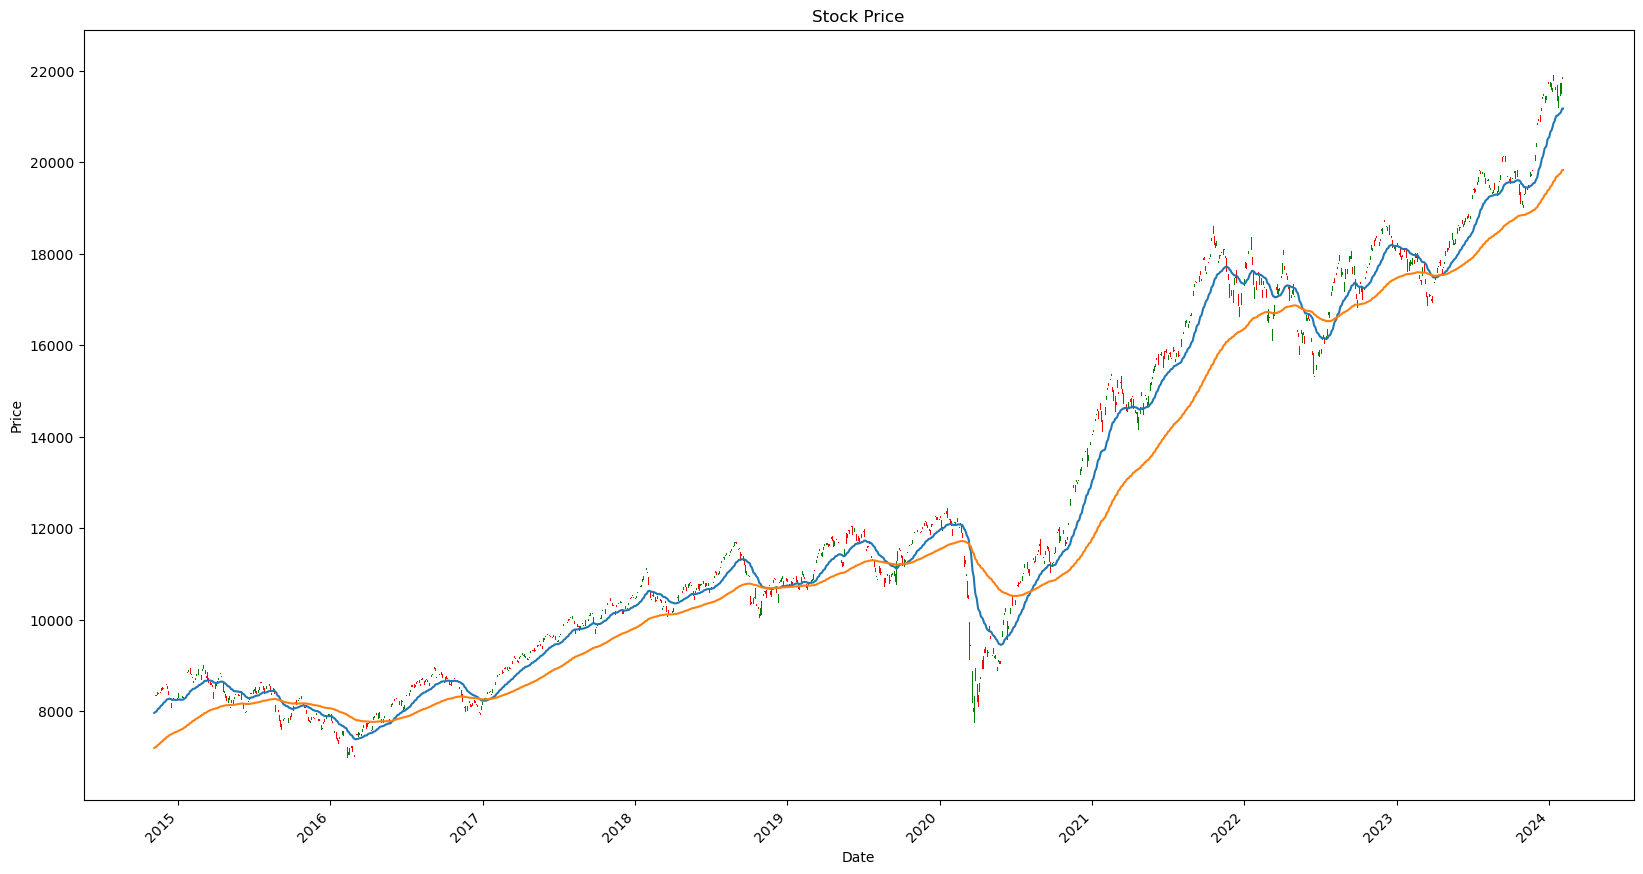

In [7]:
plt.figure()

up = nifty[nifty.Close >= nifty.Open]
down = nifty[nifty.Close < nifty.Open]

col1 = 'red'
col2 = 'green'

width = 0.8
width2 = 0.1

plt.figure(figsize=(20,10))

# Plot the up prices of the stock
plt.bar(up.index, up.Close-up.Open, width, bottom=up.Open, color=col2)
plt.bar(up.index, up.High-up.Close, width2, bottom=up.Close, color=col2)
plt.bar(up.index, up.Low-up.Open, width2, bottom=up.Open, color=col2)

# Plot the down prices of the stock
plt.bar(down.index, down.Close-down.Open, width, bottom=down.Open, color=col1)
plt.bar(down.index, down.High-down.Open, width2, bottom=down.Open, color=col1)
plt.bar(down.index, down.Low-down.Close, width2, bottom=down.Close, color=col1)


plt.plot(nifty.EMA50)
plt.plot(nifty.EMA200)
# Rotate the x-axis tick labels at 45 degrees towards right
plt.xticks(rotation=45, ha='right')

# Display the candlestick chart of stock data for a week

plt.title('Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')

plt.show()

In [10]:
features = ['Open_per', 'High_per', 'Low_per', 'Return', 'Volume','RSI', 'EMA5', 'EMA13', 'EMA26', 'EMA50', 'EMA200', 'MFI', 'MarketOpen/Close']
target = ['Close_L']

In [22]:
scaler = MinMaxScaler()
nifty_transform = scaler.fit_transform(nifty[features])
nifty_transform = pd.DataFrame(columns=features, data=nifty_transform, index=nifty.index)
nifty_target = 

In [17]:
#timesplit = TimeSeriesSplit(n_splits=450)

#for train_index, test_index in timesplit.split(nifty):
#        X_train, X_test = nifty[:len(train_index)], nifty[len(train_index): (len(train_index)+len(test_index))]
#        y_train, y_test = nifty_label[:len(train_index)].values.ravel(), nifty[len(train_index): (len(train_index)+len(test_index))].values.ravel()

#X_train, X_test, y_train, y_test = nifty_transform[:], nifty[:], nifty_label[:].values.ravel(), nifty_next_label[:].values.ravel() 

NameError: name 'nifty_next_label' is not defined

In [ ]:
trainX = np.array(X_train)
testX = np.array(X_test)

X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

In [ ]:
X_train = np.array(X_train).astype('float64')
X_test = np.array(X_test).astype('float64')
y_train = np.array(y_train).astype('float64')
y_test = np.array(y_test).astype('float64')

In [ ]:
X_test.shape

In [ ]:
lstm = Sequential()
#lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
#lstm.add(Dense(1))
#lstm.compile(loss='mean_squared_error', optimizer='adam')

lstm.add(LSTM(256, input_shape = (1, trainX.shape[1]), activation='relu', return_sequences=True))
#lstm.add(LSTM(128, return_sequences=False))
lstm.add(Dropout(0.3))
lstm.add(LSTM(128,input_shape = (1, trainX.shape[1]), activation='relu', return_sequences=True))
lstm.add(Dropout(0.2))
lstm.add(LSTM(32,input_shape = (1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dropout(0.2))
lstm.add(Dense(16))
lstm.add(Dense(4))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam', metrics=[MeanAbsoluteError()])
lstm.summary()

In [ ]:
early_stopping = EarlyStopping(monitor='loss', patience=10, mode='min', verbose=1)

# Training the model with the EarlyStopping callback
#history = lstm.fit(X_train, y_train, epochs=50, batch_size=8, verbose=1, shuffle=False, validation_data=(X_test, y_test), callbacks=[early_stopping])
history = lstm.fit(X_train, y_train, epochs=50, batch_size=8, verbose=1, shuffle=False, callbacks=[early_stopping])

In [ ]:
y_pred = lstm.predict(X_test)

plt.figure(figsize=(16,6))
plt.plot(y_test, label = 'True Value')
plt.plot(y_pred, label = 'Predicted Value')
plt.title("Prediction")
plt.xlabel('Time Scale')
plt.ylabel('Scaled')
plt.legend()
plt.show()

In [ ]:
print("MAE : ",mean_absolute_error(y_test, y_pred))
print("MSE : ",mean_squared_error(y_test, y_pred))